<a href="https://colab.research.google.com/github/zhesun0304/ECON3916/blob/main/Lab4/%5BLab%204%5D%20Descriptive%20Statistics%20%E2%80%94%20Robustness%20in%20a%20Skewed%20World.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Descriptive Statistics — Robustness in a Skewed World

count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: MedHouseVal, dtype: float64


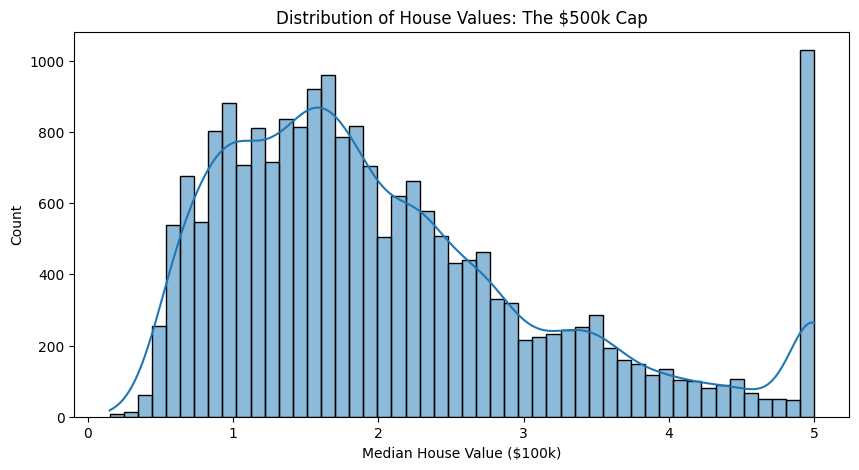

In [7]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# step 1: Setup & Inspection
# Ingesting Data
data = fetch_california_housing(as_frame=True)
df = data.frame

# Inspecting the ceiling effect
print(df['MedHouseVal'].describe())

plt.figure(figsize=(10, 5))
sns.histplot(df['MedHouseVal'], bins=50, kde=True)
plt.title("Distribution of House Values: The $500k Cap")
plt.xlabel("Median House Value ($100k)")
plt.show()

In [8]:
# Function flagging outliers based on Interquartile Range
def flag_outliers_iqr(df, column):
    # Calculate Quartiles
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define the "Tukey Fence"
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Return Boolean Mask
    return (df[column] < lower_bound) | (df[column] > upper_bound)

# Apply to Median Income
df['outlier_iqr'] = flag_outliers_iqr(df, 'MedInc')

print(f"Manual Outliers Detected: {df['outlier_iqr'].sum()}")
print("These are primarily the 'Wealthy' districts.")

Manual Outliers Detected: 681
These are primarily the 'Wealthy' districts.


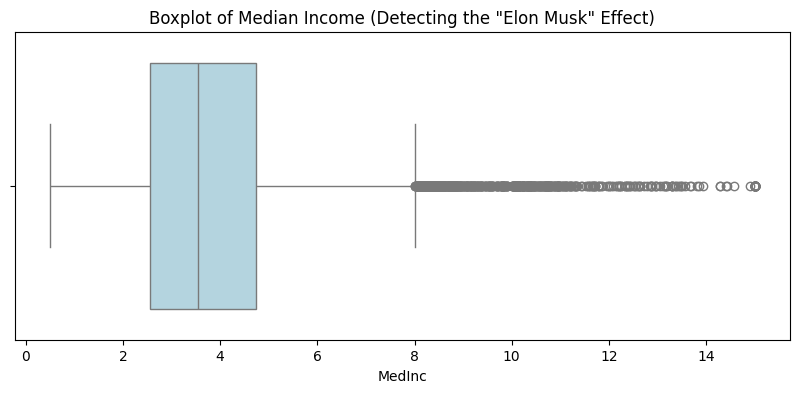

In [9]:
# Visualizing the IQR Outliers
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['MedInc'], color='lightblue')
plt.title('Boxplot of Median Income (Detecting the "Elon Musk" Effect)')
plt.show()

In [10]:
# Algorithmic Anomaly Detection
# Initiating models
# contamination = 0.05: We estimate around 5% of the data is anomalous
iso_forest = IsolationForest (n_estimators=100, contamination=0.05, random_state=42)

# Income, House Age, Average Rooms to study
features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population']

# Fit and Predict -1 as outliers and 1 as normal
preds = iso_forest.fit_predict(df[features])

# Map to boolean (True if outlier)
df['outlier_iso'] = preds == -1

print(f"Algorithmic Outliers Detected: {df['outlier_iso'].sum()}")

Algorithmic Outliers Detected: 1032


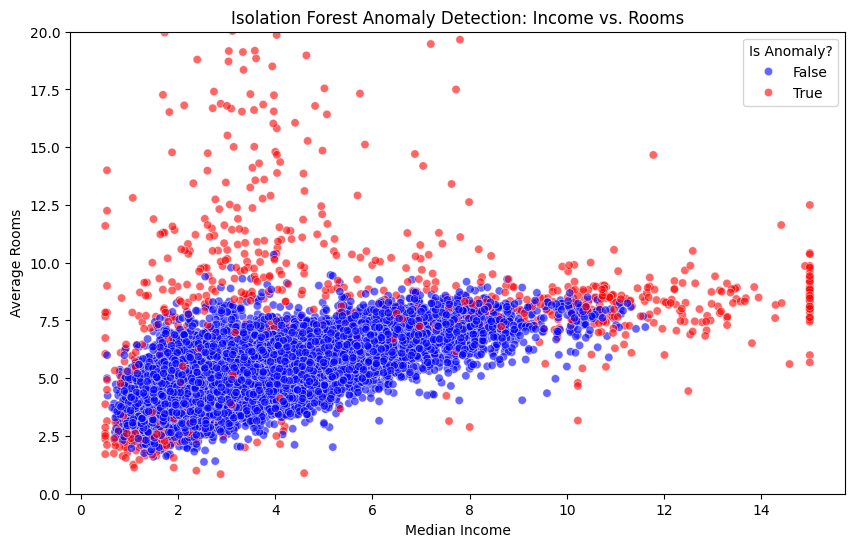

In [11]:
# Visuals in human v.s. machine
plt.figure(figsize=(10, 6))

# Plot points flagged by Isolation Forest
sns.scatterplot(
    data=df,
    x='MedInc',
    y='AveRooms',
    hue='outlier_iso',
    palette={True: 'red', False: 'blue'},
    alpha=0.6
)

plt.title("Isolation Forest Anomaly Detection: Income vs. Rooms")
plt.xlabel("Median Income")
plt.ylabel("Average Rooms")
plt.ylim(0, 20) # Zoom in to ignore extreme errors
plt.legend(title='Is Anomaly?')
plt.show()

In [12]:
# The Robustness Report
df_normal  = df[df['outlier_iso'] == False].copy()
df_outlier = df[df['outlier_iso'] == True].copy()

# Summary stats
summary_stats = pd.DataFrame({
    'Group': ['Normal', 'Outlier'],
    'MedInc_Mean': [
        df_normal['MedInc'].mean(),
        df_outlier['MedInc'].mean()
    ],
    'MedInc_Median': [
        df_normal['MedInc'].median(),
        df_outlier['MedInc'].median()
    ],
    'MedHouseVal_Mean': [
        df_normal['MedHouseVal'].mean(),
        df_outlier['MedHouseVal'].mean()
    ],
    'MedHouseVal_Median': [
        df_normal['MedHouseVal'].median(),
        df_outlier['MedHouseVal'].median()
    ]
})

# Volatility: Standard Deviation vs MAD
def mad(series):
    return (series - series.median()).abs().median()

volatility = pd.DataFrame({
    'Group': ['Normal', 'Outlier'],
    'MedInc_STD': [
        df_normal['MedInc'].std(),
        df_outlier['MedInc'].std()
    ],
    'MedInc_MAD': [
        mad(df_normal['MedInc']),
        mad(df_outlier['MedInc'])
    ],
    'MedHouseVal_STD': [
        df_normal['MedHouseVal'].std(),
        df_outlier['MedHouseVal'].std()
    ],
    'MedHouseVal_MAD': [
        mad(df_normal['MedHouseVal']),
        mad(df_outlier['MedHouseVal'])
    ]
})

# Inequality Wedge (Mean − Median) — Outliers Only
inequality_wedge = pd.DataFrame({
    'Metric': ['MedInc', 'MedHouseVal'],
    'Mean': [
        df_outlier['MedInc'].mean(),
        df_outlier['MedHouseVal'].mean()
    ],
    'Median': [
        df_outlier['MedInc'].median(),
        df_outlier['MedHouseVal'].median()
    ]
})

inequality_wedge['Inequality_Wedge'] = (
    inequality_wedge['Mean'] - inequality_wedge['Median']
)

print("\n=== Inequality Wedge (Outliers Only) ===")
print(inequality_wedge)



=== Inequality Wedge (Outliers Only) ===
        Metric      Mean   Median  Inequality_Wedge
0       MedInc  5.790782  4.25695          1.533832
1  MedHouseVal  2.668172  2.05700          0.611172


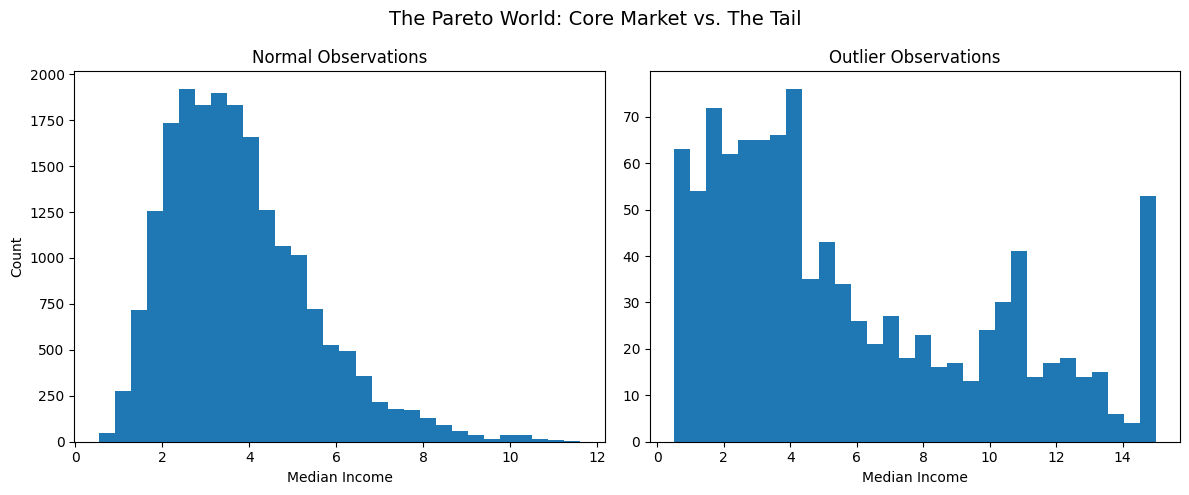

In [13]:
# Visualization — Pareto Core vs Tail
plt.figure(figsize=(12, 5))

# Left: Normal
plt.subplot(1, 2, 1)
plt.hist(df_normal['MedInc'], bins=30)
plt.title('Normal Observations')
plt.xlabel('Median Income')
plt.ylabel('Count')

# Right: Outliers
plt.subplot(1, 2, 2)
plt.hist(df_outlier['MedInc'], bins=30)
plt.title('Outlier Observations')
plt.xlabel('Median Income')

plt.suptitle('The Pareto World: Core Market vs. The Tail', fontsize=14)
plt.tight_layout()
plt.show()